# Local Invariant Features
## Computer Vision and Image Processing - Lab Session 5 - Exercises
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Alex Costanzino, alex.costanzino@unibo.it - Iacopo Curti, iacopo.curti2@unibo.it

### Exercise 1: Object Detection
Given a query image ('ex/bishop.jpg') detect the object in the scene images: 'scene1.jpg', 'scene2.jpg' and 'scene3.jpg'.

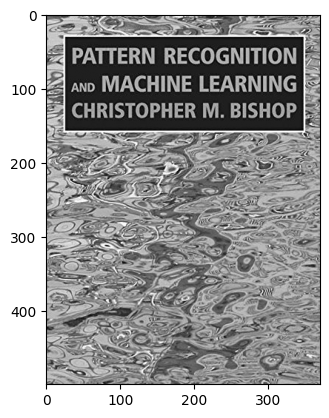

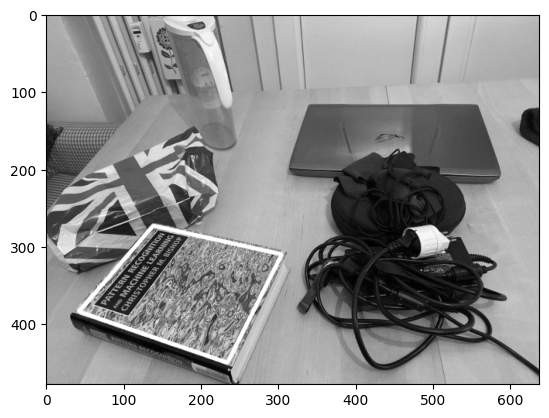

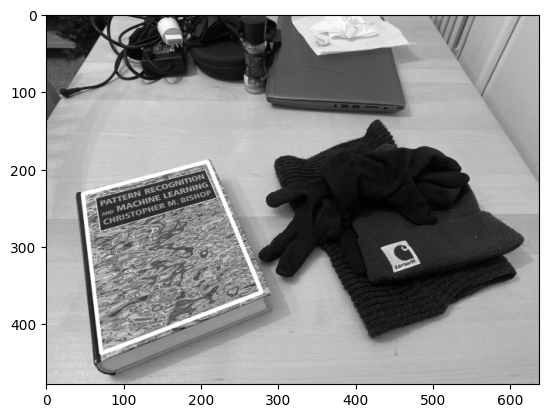

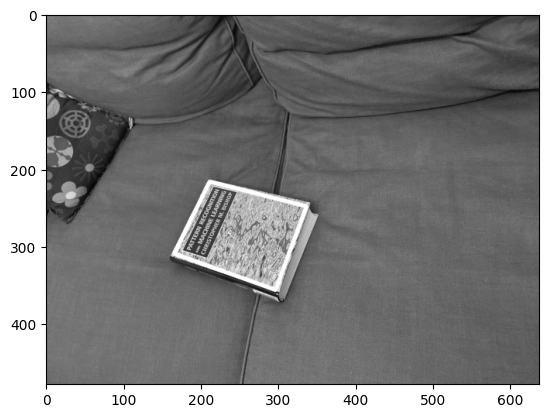

In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img_query = cv2.imread('ex/bishop.jpg', 0)
plt.imshow(img_query, cmap='gray',vmin=0, vmax=255)
plt.show()
scene1 = cv2.imread('ex/scene1.jpg', 0)
# plt.imshow(scene1, cmap='gray',vmin=0,vmax=255)
# plt.show()
scene2 = cv2.imread('ex/scene2.jpg', 0)
# plt.imshow(scene2, cmap='gray',vmin=0,vmax=255)
# plt.show()
scene3 = cv2.imread('ex/scene3.jpg', 0)
# plt.imshow(scene3, cmap='gray',vmin=0,vmax=255)
# plt.show()

### detect keypoints ###

sift = cv2.SIFT_create()
kp_query = sift.detect(img_query)
kp_scene1 = sift.detect(scene1)
kp_scene2 = sift.detect(scene2)
kp_scene3 = sift.detect(scene3)

### compute descriptors ###

kp_query, desc_query = sift.compute(img_query, kp_query)
kp_scene1, desc_scene1 = sift.compute(scene1, kp_scene1)
kp_scene2, desc_scene2 = sift.compute(scene2, kp_scene2)
kp_scene3, desc_scene3 = sift.compute(scene3, kp_scene3)
# print(desc_query.shape, desc_scene1.shape, desc_scene2.shape, desc_scene3.shape)

### find correspondences ###

# parametri per l'algoritmo di ricerca
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
# Matching and finding the 2 closest elements for each query descriptor.
matches_scene1 = flann.knnMatch(desc_query, desc_scene1, k=2)
matches_scene2 = flann.knnMatch(desc_query, desc_scene2, k=2)
matches_scene3 = flann.knnMatch(desc_query, desc_scene3, k=2)
# filter bad matches

def filter_bad_matches(matches):
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return good
    
good_scene1 = filter_bad_matches(matches_scene1)
good_scene2 = filter_bad_matches(matches_scene2)
good_scene3 = filter_bad_matches(matches_scene3)

### Detect the object

def find_object(kp_query, kp_train, good_matches, img_query, img_train):
    # Checking if we found enough matching
    MIN_MATCH_COUNT = 10
    if len(good_matches)>MIN_MATCH_COUNT:
        # building the corrspondences arrays of good matches
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist() # ravel è sinonimo di unravel, trasforma l'array numpy 2d (n, 1), in un array 1d (n,)
        # Corners of the query image
        h,w = img_query.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts,M)
        # Drawing the bounding box
        img_train = cv2.polylines(img_train, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
        plt.imshow(img_train, "gray")
        plt.show()
        return True, matchesMask
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
        return False, matchesMask

find_object(kp_query, kp_scene1, good_scene1, img_query, scene1)
find_object(kp_query, kp_scene2, good_scene2, img_query, scene2)
find_object(kp_query, kp_scene3, good_scene3, img_query, scene3)

### Exercise 2: Image Search
Given a query image ('ex/bishop.jpg') and several train images ('ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg', 'ex/scene4.jpg', 'ex/scene5.jpg') implement an image search algorithm to find which images contain the query object.

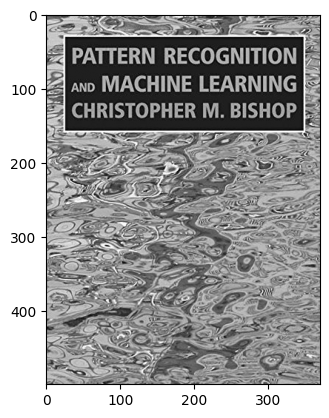

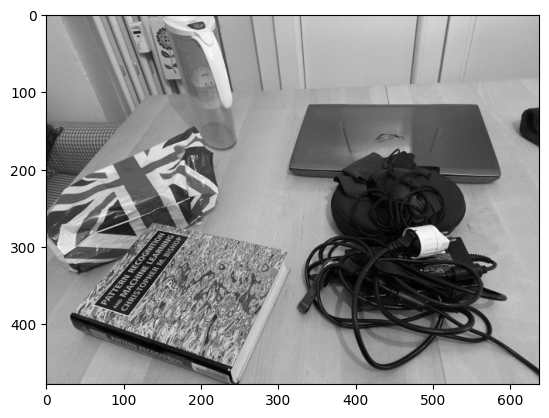

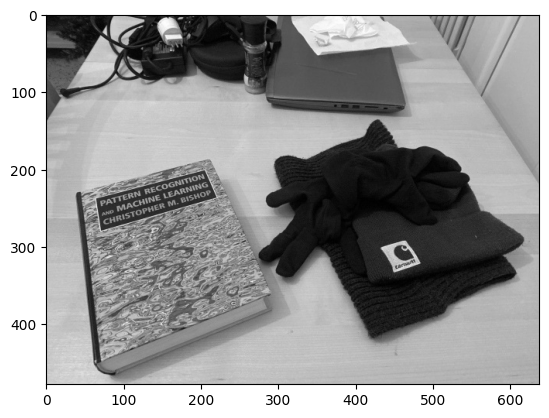

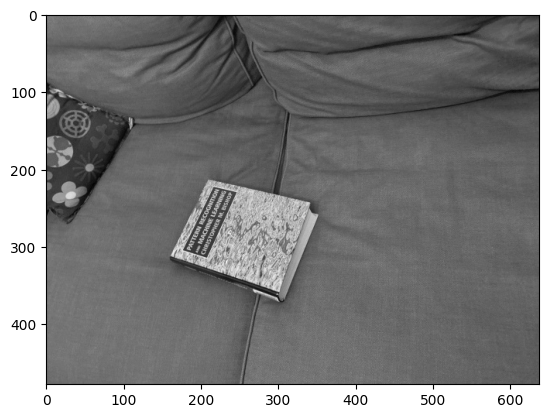

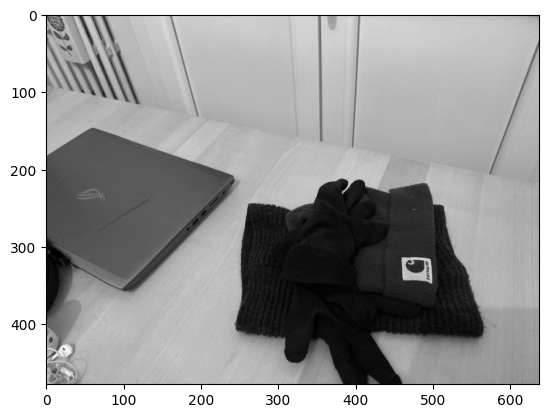

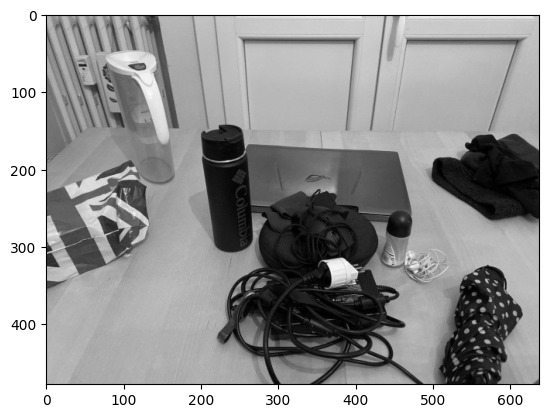

Not enough matches are found - 10/10


In [27]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img_query = cv2.imread('ex/bishop.jpg', 0)
scene1 = cv2.imread('ex/scene1.jpg', 0)
scene2 = cv2.imread('ex/scene2.jpg', 0)
scene3 = cv2.imread('ex/scene3.jpg', 0)
scene4 = cv2.imread('ex/scene4.jpg', 0)
scene5 = cv2.imread('ex/scene5.jpg', 0)
plt.imshow(img_query, cmap='gray',vmin=0, vmax=255)
plt.show()
plt.imshow(scene1, cmap='gray',vmin=0,vmax=255)
plt.show()
plt.imshow(scene2, cmap='gray',vmin=0,vmax=255)
plt.show()
plt.imshow(scene3, cmap='gray',vmin=0,vmax=255)
plt.show()
plt.imshow(scene4, cmap='gray',vmin=0,vmax=255)
plt.show()
plt.imshow(scene5, cmap='gray',vmin=0,vmax=255)
plt.show()

def detect_instance(img_query, img_train):
    sift = cv2.SIFT_create()
    # detect keypoints
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    # compute descriptors
    kp_query, desc_query = sift.compute(img_query, kp_query)
    kp_train, desc_train = sift.compute(img_train, kp_train)
    # find correspondences 
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc_query, desc_train, k=2)
    # filtriamo le correspondenze trovate
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)
            
    MIN_MATCH_COUNT = 10
    conta_match = 0
    
    if len(good_matches)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        # L'omografia non mi serve, la uso per filtrare con RANSAC ulteriori match sbagliati (quelli che portano ad avere un'omografia con reprojection error troppo alto) 
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist() # ravel è sinonimo di unravel, trasforma l'array numpy 2d (n, 1), in un array 1d (n,)
        for vote in mask:
            if vote == 1:
                conta_match += 1
        if conta_match > MIN_MATCH_COUNT:
            return True, matchesMask
        else:
            return False, matchesMask
    else:
        print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
        return False, None
    

found1, matches_mask1 = detect_instance(img_query, scene1)
found2, matches_mask2 = detect_instance(img_query, scene2)
found3, matches_mask3 = detect_instance(img_query, scene3)
found4, matches_mask4 = detect_instance(img_query, scene4)
found5, matches_mask5 = detect_instance(img_query, scene5)

### Exercise 3: Mosaicing (aka Panorama Stitching)

Given two images stitch them in a single image. 

Test it on the couples 'ex/bologna_left.jpg' and 'ex/bologna_right.jpg', 'ex/bologna_logo_left.jpg' and  'ex/bologna_logo_right.jpg', 'ex/front_gallery_left.jpg' and 'ex/front_gallery_right.jpg','ex/gallery_left.jpg' and 'ex/gallery_right.jpg','ex/wall_left.jpg' and 'ex/wall_right.jpg'.

_Tips:_ 
* Find correspondences between the images within each couple
* Find an homography
* Warp one image and restore values for the other image 

In [ ]:
# Write your solution here

### Exercise 4: Augmentated Reality 
Given an image ('ex/stregatto.jpg') implement an augmented reality algorithm to project the image into the surface of the query object ('ex/bishop.jpg).

Moreover, restore the values of the original scene image instead of black pixels obtained with warping. 

Test it on scene images 'ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg'.

_Expected Results_:

<img src="LabSession5Images/ar_ex.png" width="400">

In [ ]:
# Write your solution here